<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-the-full-dataset-(not-deleting-days-without-any-sick-CPEs)" data-toc-modified-id="Importing-the-full-dataset-(not-deleting-days-without-any-sick-CPEs)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing the full dataset (not deleting days without any sick CPEs)</a></span></li><li><span><a href="#Importing-the-training-dataset" data-toc-modified-id="Importing-the-training-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing the training dataset</a></span></li><li><span><a href="#Evaluating-the-cutoff-probabilities" data-toc-modified-id="Evaluating-the-cutoff-probabilities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluating the cutoff probabilities</a></span></li><li><span><a href="#More-test-dates" data-toc-modified-id="More-test-dates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>More test dates</a></span></li><li><span><a href="#Influence-of-the-time-gap-between-training-dates-and-testing-dates" data-toc-modified-id="Influence-of-the-time-gap-between-training-dates-and-testing-dates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Influence of the time gap between training dates and testing dates</a></span></li></ul></div>

In [112]:
# Some important imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context('notebook')

# Sklearn imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Own Scripts import
from scripts.utils import *
from scripts.preprocessing import *
from scripts.plot import *
from scripts.model_selection import *

# get rid of warning due to deprecated modules in sklearn
import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing the full dataset (not deleting days without any sick CPEs)
We want to keep those days because we need the most recently collected samples and those do not yet have any sick labels as data collection waits 8 days for the FTR flag to be set before deciding on the health of the CPE.

In [4]:
DATA_FOLDER = './Data'
s_day = '11_06'
DATA_PATH = DATA_FOLDER + '/sample_'+s_day+'.xlsx'
BACKUP_PATH = DATA_FOLDER+'/sample_'+s_day+'.pk'

full_extracted = import_sample(DATA_PATH,BACKUP_PATH,delete_only_healthy_days=False)
full_dates = full_extracted['day_0'].values

Retrieving from ./Data/sample_11_06_full.pk
The sample is composed of : 20715 vectors of dimension 291
	n_sick		=   5733
	n_healthy	=  14982


In [5]:
# we get the most recent day to build the test set
test_extracted = full_extracted[full_extracted['day_0'] == np.max(np.unique(full_dates))]
x_extracted_te, y_extracted_te = get_ml_data(test_extracted)
x_encoded_te = encode_categorical(x_extracted_te)
x_te_df = remove_features(x_encoded_te,verbose = True)
x_te = x_te_df.values

Deleting 54 features (18.305%).


# Importing the training dataset 
We need to have the labels for such dates. 

In [6]:
# and finally we get all the days where we can train
extracted = import_sample(DATA_PATH,BACKUP_PATH)
dates = extracted['day_0'].values
x_extracted_tr, y_extracted_tr = get_ml_data(extracted)

y_tr = convert_to_binary_labels(y_extracted_tr)
x_encoded_tr = encode_categorical(x_extracted_tr)
x_tr_df = remove_features(x_encoded_tr,verbose = True)
x_tr = x_tr_df.values

Retrieving from ./Data/sample_11_06_sick_only.pk
The sample is composed of : 18636 vectors of dimension 291
	n_sick		=   5733
	n_healthy	=  12903
Deleting 54 features (18.305%).


In [116]:
estimator = lambda kw_args: make_pipeline(sklearn.preprocessing.Imputer(strategy='mean'),
                                          preprocessing.StandardScaler(),
                                          sklearn.ensemble.GradientBoostingClassifier(**kw_args))
best_args = {'learning_rate': 0.050000000000000003,
   'max_depth': 11,
   'min_samples_split': 600,
   'n_estimators': 100}
pipeline = estimator(best_args)

# Evaluating the cutoff probabilities

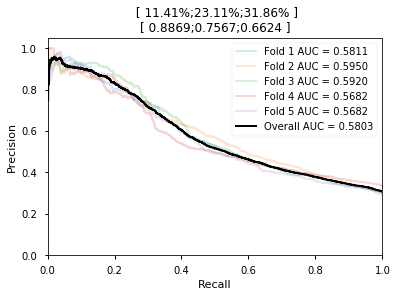

In [8]:
fig, ax = plt.subplots()
evaluate_recall_for_precision(ax, estimator(best_args), x_tr, y_tr, dates,'',prec_thresh_list=[0.9,0.8,0.7],cv=5)

In [9]:
# save the model to disk
import pickle,os
filename = './Data/finalized_model.sav'
if(not os.path.isfile(filename)):
    pipeline.fit(x_tr,y_tr)
    pickle.dump(pipeline, open(filename, 'wb'))
    clf = pipeline
else:
    # load model
    clf = pickle.load(open(filename, 'rb'))

In [10]:
sick_probas = clf.predict_proba(x_te)[:,1]
test_extracted['sick_proba'] = sick_probas
test_extracted[test_extracted['sick_proba'] >= 0.7556]

,weekday,day_0,mac,cly_account_number,saa_account_number,cmts,service_group,hardware_model,n_cpe_building,offline_pct_6h,...,cmts_utilization_dn_18h,cmts_utilization_dn,cmts_utilization_dn_1d,cmts_utilization_dn_2d,cmts_utilization_dn_3d,cmts_utilization_dn_4d,cmts_utilization_dn_5d,seq_id,milestone_name,sick_proba
20196,6,2018-06-10,546751F40E59,6219737,6219737,ch-mbcLOC301,RW25,0,17,16.666667,...,-0.969167,12.788516,NaN,NaN,NaN,NaN,NaN,31653587,NaN,0.774174


# More test dates

Having only one prediction to check is not enough to discuss the model output with the HFC support expert, therefore we decided to take a bit more days in consideration. It will limit the ability to analyse them as we have a limited history period in Self Assure.

In [11]:
# we get the most recent day to build the test set
test_extracted = full_extracted[full_extracted['day_0'].isin(np.setdiff1d(full_dates,dates))]
x_extracted_te, y_extracted_te = get_ml_data(test_extracted)
x_encoded_te = encode_categorical(x_extracted_te)
x_te_df = remove_features(x_encoded_te,verbose = True)
x_te = x_te_df.values

Deleting 54 features (18.305%).


In [12]:
sick_probas = clf.predict_proba(x_te)[:,1]
test_extracted['sick_proba'] = sick_probas
test_extracted[test_extracted['sick_proba'] >= 0.7556]

,weekday,day_0,mac,cly_account_number,saa_account_number,cmts,service_group,hardware_model,n_cpe_building,offline_pct_6h,...,cmts_utilization_dn_18h,cmts_utilization_dn,cmts_utilization_dn_1d,cmts_utilization_dn_2d,cmts_utilization_dn_3d,cmts_utilization_dn_4d,cmts_utilization_dn_5d,seq_id,milestone_name,sick_proba
13744,5,2018-05-19,905C44171E3B,5663146,5663146,mbcCHR301,RW85,0,4,0.000000,...,2.464896,11.082812,0.338516,-0.625000,-0.362214,0.810781,-0.015156,21798468,NaN,0.878077
13803,5,2018-05-19,5467518B1C02,678993,678993,ch-mbcAMO301,RW07,0,43,NaN,...,-3.720312,26.944036,7.533854,-3.300807,-1.294115,-3.196578,3.237333,21625733,NaN,0.763577
16790,0,2018-05-28,546751ACAC08,5623418,5623418,ch-mbcALT301,RW13,0,5,66.666667,...,NaN,34.181432,NaN,NaN,NaN,NaN,NaN,26078300,NaN,0.878327
16792,6,2018-05-27,5467518B1B0F,6536538,6536538,ch-mbcWNT301,RW07,0,9,100.000000,...,-3.132917,13.481536,1.152344,1.952344,-2.613542,0.980104,0.622396,25589372,NaN,0.818467
16876,0,2018-05-28,5467518A587B,6032633,6032633,mbcNAX302,629-648645-648,0,4,0.000000,...,-2.411771,25.353698,-3.030615,4.457990,4.102286,-3.523198,0.404109,26044465,NaN,0.870717
16883,6,2018-05-27,905C44194F50,946512,946512,ch-mbcFRR301,RW12,0,3,0.000000,...,-11.005729,18.122031,1.057604,4.580365,1.521927,0.555104,-1.148021,25746973,NaN,0.879746
16988,0,2018-05-28,AC220510637C,6070718,6070718,mbcBYB302,RW34,0,4,66.666667,...,-7.828542,17.751250,-4.874974,3.185651,-0.123385,3.215208,-1.484401,26354382,NaN,0.903593
19089,2,2018-06-06,905C44BF6396,6586897,6586897,mbcBIE301,RW113,0,3,16.666667,...,0.280313,8.525547,-0.585964,0.120182,-0.764167,NaN,NaN,29859091,NaN,0.783860
19269,3,2018-06-07,C427951777A7,6036968,6036968,ch-mbcMDR301,RW07,4,11,0.000000,...,-1.493125,8.181250,0.169740,-0.916823,-0.212839,-0.375443,-0.117637,30451867,NaN,0.821313
20196,6,2018-06-10,546751F40E59,6219737,6219737,ch-mbcLOC301,RW25,0,17,16.666667,...,-0.969167,12.788516,NaN,NaN,NaN,NaN,NaN,31653587,NaN,0.774174


We decided to check 4 different devices to see if they indeed experienced some problem:
    
- ```546751F40E59``` ($p = 0.774174$): A HFC interface keeps resetting (a lot), during this period the customer has no connection. Probably a hardware modem issue. **True Positive**
- ```AC22059AC221``` ($p = 0.892083$): Went offline for an extended amount of time. The only problem seems to be a lot of missing values, there are a lot of timeouts and it might be a data collection issue. **False Positive**
- ```C427951777A7``` ($p = 0.821313$): Lots of packets are dropped on one of the channel, this can result for the customer in performance issues (service degradations). It is most probably a cabling problem that he can solve himself if we send him a repalcement cable. **True Positive**
- ```905C44BF6396``` ($p = 0.783860$): We can see that levels were down for an extended period of time and went back up, which should indicate a technician intervention. We couldn't find it but given the similarities we can conclude that this is a **True Positive**

HFC support expressed satisfaction with respect to these results as out of the 4 predictions we analyzed only one was a false positive and it was still displaying irregularities. 

# Influence of the time gap between training dates and testing dates

It would now be interesting to look at how much time can we wait between the model is trained and is used to predict. because we do not have that many days of data we will limit this analysis but the main idea is to see whether the model needs to be retrained every day or every 3 days, every week etc.

We first find the longest common sequence in the list of distinct dates.

In [53]:
import copy
from datetime import timedelta

def get_longest_date_seq(dates,verbose = True):
    """
    Returns the longuest sequence (consecutive) of dates as a list of dates.
    
    @params:
    - dates: a numpy array of dates where we wish to find the longuest sequence
    - verbose: can be set to True if we wish to print the details of the longuest sequence found
    """
    days = sorted(list(pd.to_datetime(np.unique(dates))))
    assert(len(days) != 0), 'There are no dates'
    max_seq = []
    max_l = 0

    curr_seq = []
    curr_l = 0

    for d in days[1:]:
        if len(curr_seq)==0:
            curr_seq = [d]
            curr_l = 1
        elif(d == curr_seq[-1] + timedelta(days=1)):
            curr_seq.append(d)
            curr_l += 1
        else:
            if(curr_l > max_l):
                # we replace the max sequence only if it is longer than the max one
                max_seq = copy.deepcopy(curr_seq)
                max_l = curr_l

                curr_seq = []
                curr_l = 0
    if(verbose):
        print('The longuest sequence of dates has length {}:\n\tS: {}\n\tE: {}'.format(max_l,max_seq[0],max_seq[-1]))        
    return max_seq

In [55]:
dates_to_consider = get_longest_date_seq(dates)

The longuest sequence of dates has length 41:
	S: 2018-04-08 00:00:00
	E: 2018-05-18 00:00:00


With 41 days to work with we now need to decide on a strategy to use such dates. We would like to see the influence of the gap period $\in\{0,...7\}$ (= difference between last day of training and first day of testing).

*We want to keep the training set size a constant such that it doesn't influence the performance of the model*

Also we would like to repeat the operation multiple times in order to have a representative metric in the end. What we will do is try to use 25% of the dataset to test for the largest gap length. Here we want to have 7 days at most of gap:
- 8 different testing rounds (on 8 testing days)
- a training set of size 26 days for each round and for all the gap length

Therefore when ```gap_length = 7```, what we do is that the first training round will take:
- training set: Day_1 to Day_26
- testing set: Day_34
... until the 8th round:
- training set: Day_8 to Day_33
- testing set: Day_41

and when ```gap_length = 1```, the first round is:
- training set: Day_1 to Day_26
- testing set: Day_28
... until the 8th round:
- training set: Day_8 to Day_33
- testing set: Day_35

Then in order to reduce the number of trainings that take time we see that for each gap_length:
* At each round the training set is identical and only the testing set is different.
* Therefore we can train a model as many time as we have different gap_length and evaluate on each training set. 
* we will concatenate for each gap length ```true_y``` and ```score_y``` that are computed at each round to have a good estimate of the performance.

In [153]:
import math

def plot_gap_performance(x,y,dates,model,gaps,ratio_testing=0.25):
    """
    Plots the Recall Precision curve for different time gaps between the training and testing.
    
    @params:
    - x,y: the input and labels
    - model: the machine learning model we wish to evaluate
    - gaps: list of time gaps between the last training date and testing date
    - ratio_testing: the ratio of usable days we wich to use in order to 
    have a meaningful performance evaluation
    """
    dates_to_consider = get_longest_date_seq(dates,verbose=False)

    max_gap = max(gaps)
    usable_days = len(dates_to_consider) - max_gap
    testing_days = math.floor(ratio_testing*usable_days)
    training_days = usable_days - testing_days

    progress(0, testing_days)

    # generate training sets.
    day_0 = dates_to_consider[0]
    training_sets_dates = [[day_0 + timedelta(days=first_day_delta) +
                            timedelta(days=i) for i in range(0, training_days)]
                           for first_day_delta in range(0, testing_days)]

    dates_pd = pd.to_datetime(dates)

    # to store the results
    true_y = {g: [] for g in gaps}
    score_y = {g: [] for g in gaps}
    i = 1

    for tr_d in training_sets_dates:
        tr_mask = dates_pd.isin(tr_d)
        x_training = x[tr_mask]
        y_training = y[tr_mask]

        # fit the model
        model.fit(x_training, y_training)

        # print the progress
        progress(i, testing_days)
        i+=1

        for g in gaps:
            te_d = tr_d[-1] + timedelta(days=g + 1)
            te_mask = [dates_pd == te_d]
            x_testing = x[te_mask]
            y_testing = y[te_mask]

            # test the model and get predictions
            scores = model.predict_proba(x_testing)[:, 1]
            true_y[g].append(y_testing)
            score_y[g].append(scores)

    fig, ax = plt.subplots()
    for g in gaps:
        precision, recall, threshold = sklearn.metrics.precision_recall_curve(
            np.concatenate(true_y[g]), np.concatenate(score_y[g]))
        lab = 'Gap = {}d, AUC = {:.4f}'.format(
            g, sklearn.metrics.auc(recall, precision))
        ax.step(recall, precision, alpha=0.5, where='post', label=lab)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(
        'Comparison of performance with\ndifferent training-testing time gaps')
    ax.legend(loc='upper right', fontsize='small')

[############################################################] 100.0% (8/8) 


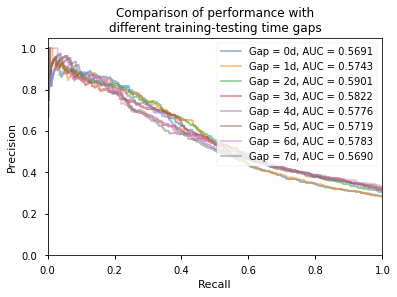

In [133]:
plot_gap_performance(x_tr,y_tr,dates,pipeline,list(range(0,8)))

[############################################################] 100.0% (7/7) 


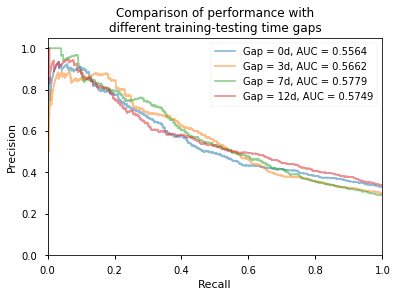

In [154]:
plot_gap_performance(x_tr,y_tr,dates,pipeline,[0,3,7,12])

We can see that there is no significant difference between the performance of the models whatever the time gap between training and testing which is reassuring as it means that we have already taken out a good part of the seasonality of the data. But it also ensures that it is okay that the training set is in real life 8 days younger than the testing set (because of the FTR flag)